In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum==0.4.0 neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
use_neptune = True

In [4]:
import neptune
import tensorflow as tf
import random

import io
import cirq
import numpy as np
import statistics as st
from matplotlib import pyplot as plt
from collections import defaultdict
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.circuits import get_discriminator
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.phase.string_order_parameters import measure_szy_pauli_string, measure_s1_pauli_string
from qsgenerator.states.butterfly_circuits import ButterflyCircuitBuilder
from qsgenerator.quwgans.real_expectations_provider import PrecomputedExpectationsProvider, \
    Interpolation1DExpectationsProvider, WassersteinGanExpectationProvider, ExpectationProviderType
from qsgenerator.states.simple_rotation_generators import get_fixed_random_rotation_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [21]:
generator_layers = 4
data_bus_size = 5
rank = 6
k = 3
real_circuit_type = 'phase'
generic_generator = True
zxz = False
all_gates_parametrized = False
expectation_provider_type = ExpectationProviderType.ONLY_KNOWN
g_values = [-1, -0.5, 0]
# known_g_values = list(range(32))
known_g_values = [np.round(el, 1) for el in np.linspace(-1,0,11)]
# known_g_values = [-1, -0.75, -0.5, -0.25, 0]
if expectation_provider_type == ExpectationProviderType.WGAN:
        gen_input_dim = 16
        hidden_dim = [32, 64]
        penalty_factor = 10
        gan_epochs = 10000
        batch_size = 8
known_g_values = g_values
g_positive=True

In [22]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [23]:
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False, g_positive=g_positive)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

In [24]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    if real_circuit_type == 'butterfly':
        gen, gs = ButterflyCircuitBuilder("g").build(qubits=qubits)
    else:
        builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
        gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [25]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


(0, 0): ───H───@─────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                         │
(0, 1): ───────X───Z───Ry(theta_r)───H───X───H───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                               │                                       │
(0, 2): ─────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                               │                                       │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                               │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [26]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───Rx(g0)───Rz(g5)───ZZ────────────────Rx(g14)───Rz(g19)───ZZ────────────────Rx(g28)───Rz(g33)───ZZ────────────────Rx(g42)───Rz(g47)───ZZ────────────────
                             │                                     │                                     │                                     │
(0, 1): ───Rx(g1)───Rz(g6)───ZZ^g10───ZZ───────Rx(g15)───Rz(g20)───ZZ^g24───ZZ───────Rx(g29)───Rz(g34)───ZZ^g38───ZZ───────Rx(g43)───Rz(g48)───ZZ^g52───ZZ───────
                                      │                                     │                                     │                                     │
(0, 2): ───Rx(g2)───Rz(g7)───ZZ───────ZZ^g12───Rx(g16)───Rz(g21)───ZZ───────ZZ^g26───Rx(g30)───Rz(g35)───ZZ───────ZZ^g40───Rx(g44)───Rz(g49)───ZZ───────ZZ^g54───
                             │                                     │                                     │                                     │
(0, 3): ───Rx(g3)───Rz(g8)───ZZ^g11───ZZ───────Rx(g17)───Rz(g22)───ZZ^g25───ZZ───────Rx(g31)───Rz(g36)───ZZ^g39───ZZ───────Rx(g45)───Rz(g50)───ZZ^g53───ZZ───────
                                      │                                     │                                     │                                     │
(0, 4): ───Rx(g4)───Rz(g9)────────────ZZ^g13───Rx(g18)───Rz(g23)────────────ZZ^g27───Rx(g32)───Rz(g37)────────────ZZ^g41───Rx(g46)───Rz(g51)────────────ZZ^g55───

In [27]:
opt = tf.keras.optimizers.Adam(0.1, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [28]:
def get_expectation_provider(real, real_symbols, known_g_values, real_values_provider):
    precomputed_expectation_provider = PrecomputedExpectationsProvider(real,
                                                                       real_symbols,
                                                                       known_g_values,
                                                                       real_values_provider)
    if expectation_provider_type == ExpectationProviderType.ONLY_KNOWN:
        return precomputed_expectation_provider
    elif expectation_provider_type == ExpectationProviderType.INTERPOLATION1D:
        return Interpolation1DExpectationsProvider(precomputed_expectation_provider)
    elif expectation_provider_type == ExpectationProviderType.WGAN:
        return WassersteinGanExpectationProvider(precomputed_expectation_provider, gen_input_dim, hidden_dim, penalty_factor, gan_epochs, batch_size)

In [29]:
real_expectations_provider = get_expectation_provider(real, real_symbols, known_g_values, real_values_provider)

In [30]:
trainer_p = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  real_expectations_provider,
                  rank=rank,
                  use_neptune=use_neptune,
                  k=k)

In [20]:
epochs = 501
gen_iteration = 1
snapshot_interval_epochs = 100

In [21]:
def start_neptune_experiment(trainer, gen=None, description=None):
    if use_neptune:
        if gen is None:
            gen = trainer.gen
        neptune.init(project_qualified_name='wiktor.jurasz/thesis-em2', api_token=neptun_token)
        neptun_params = {
            'generator_layers': generator_layers,
            'size':  data_bus_size,
            'rank': rank,
            'k': k,
            'real_circuit_type': real_circuit_type,
            'generic_generator': generic_generator,
            'zxz': zxz,
            'all_gates_parametrized': all_gates_parametrized,
            'g_values': g_values,
            'expectation_provider_type': expectation_provider_type,
            'known_g_values': known_g_values,
            'gen_iteration': gen_iteration,
            'epochs': epochs,
            'real_circuit_type': real_circuit_type,
            'g_positive': g_positive
        }
        if expectation_provider_type == ExpectationProviderType.WGAN:
            gan_params = {
                'gen_input_dim': gen_input_dim,
                'hidden_dim': hidden_dim,
                'penalty_factor': penalty_factor,
                'gan_epochs': gan_epochs,
                'batch_size': batch_size
            }
            neptun_params = {**neptun_params, **gan_params}
        neptune.create_experiment(name=None, description=description, params=neptun_params)
        neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
        neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

In [22]:
start_neptune_experiment(trainer, gen)

NameError: name 'trainer' is not defined

In [23]:
json_result = trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

NameError: name 'trainer' is not defined

In [24]:
import tensorflow_quantum as tfq
ex =  tfq.layers.Expectation()
ps = cirq.PauliString([cirq.Z(qubits[1]), cirq.Y(qubits[2]), cirq.Y(qubits[3]), cirq.Z(qubits[4])])

In [25]:
ex([trainer.real_evaluator.get_resolved_circuit()], operators=ps)

NameError: name 'trainer' is not defined

In [26]:
ex([trainer.gen_evaluator.get_resolved_circuit()], operators=ps)

NameError: name 'trainer' is not defined

In [27]:
if use_neptune:
    neptune.stop()

NeptuneUninitializedException: 
[95m     
----NeptuneUninitializedException---------------------------------------------------------------------------------------
[0m
You must initialize neptune-client before you create an experiment.

Looks like you forgot to add:
    [96mneptune.init(project_qualified_name='WORKSPACE_NAME/PROJECT_NAME', api_token='YOUR_API_TOKEN')[0m
    
before you ran:
    [96mneptune.create_experiment()[0m
    
You may also want to check the following docs pages:
    - https://docs-legacy.neptune.ai/getting-started/quick-starts/log_first_experiment.html
    
[92mNeed help?[0m-> https://docs-legacy.neptune.ai/getting-started/getting-help.html


In [ ]:
def compute_known_states_stats(tra, g_list):
       return compute_states_stats(
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        g_list,
        g_list
    ) 

def compute_generated_states_stats(tra, g_list):
    return compute_states_stats(
        lambda g: tra.gen_evaluator.get_state_from_params()[1],
        lambda g: tra.real_evaluator.get_state_from_params(labels=g)[1],
        ["GENERATED"],
        g_list
    )

def compute_states_stats(state_prov1, state_prov2, g_list1, g_list2):
    stats = {
        'min_fidelity': 1,
        'min_fidelity_tuple': (None, None),
        'max_fidelity': 0,
        'max_fidelity_tuple': (None, None),
        'average_fidelity': None,
        'std_fidelity': None
    }
    fids = []
    for g1 in g_list1:
        for g2 in g_list2:
            if g1 != g2:
                state1 = state_prov1(g1)
                state2 = state_prov2(g2)
                fid = cirq.fidelity(state1, state2)
                fids.append(fid)
                if fid < stats['min_fidelity']:
                    stats['min_fidelity'] = fid
                    stats['min_fidelity_tuple'] = (g1, g2)
                if fid > stats['max_fidelity']:
                    stats['max_fidelity'] = fid
                    stats['max_fidelity_tuple'] = (g1, g2)
                
    stats['average_fidelity'] = st.mean(fids)
    stats['std_fidelity'] = st.stdev(fids)
    return stats

In [ ]:
compute_known_states_stats(trainer, known_g_values)

In [ ]:
compute_generated_states_stats(trainer, known_g_values)

In [ ]:
from scipy.optimize import linprog
def get_em_distance(W, H, t):
    traces = (t.get_all_generator_expectations(H).numpy() - t.get_real_expectation(H)).flatten()
    return sum(x * y for x, y in zip(W, traces))

def get_em_distance_real(t1, t2):
    traces = (t1.get_real_expectation(t1.disc_hamiltonians) - t2.get_real_expectation(t2.disc_hamiltonians)).flatten()
    res = linprog(-traces, A_ub=t1.A, b_ub=t1.b, bounds=(0, 1))
    tt = [traces[i] for i in range(len(t1.disc_hamiltonians)) if res.x[i] > 1.e-5]
    res2 = [res.x[i] for i in range(len(res.x)) if res.x[i] > 1.e-5]
    return sum(x * y for x, y in zip(res2, tt))

def get_em_distance2(W, H, t):
    traces = (t.get_all_generator_expectations(t.disc_hamiltonians).numpy() -
              t.get_real_expectation(t.disc_hamiltonians)).flatten()
    res = linprog(-traces, A_ub=t.A, b_ub=t.b, bounds=(0, 1))
    tt = [traces[i] for i in range(len(t.disc_hamiltonians)) if res.x[i] > 1.e-5]
    res2 = [res.x[i] for i in range(len(res.x)) if res.x[i] > 1.e-5] 
    return sum(x * y for x, y in zip(res2, tt)), res2, tt

def plot_em_distance_between_real():
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
    # g=-0.4
    # W, H = list(zip(*g_dict[g].last_run_generator_weights[-1].disc_w_h.items()))
    # get_em_distance(W, H, g_dict[-0.5]), g_dict[g].last_run_generator_weights[-1].em_distance
    g_values2 = [np.round(el, 1) for el in np.linspace(-1,0,11)]
    tr = {}
    for g in g_values2:
        tr[g] = Trainer(real, real_symbols, gen, gs, [g], real_values_provider, rank=rank, use_neptune=False)
    x = g_values2
    for g1 in g_values2:
        tmp_res = []
        for g2 in g_values2:
            tmp_res.append(get_em_distance_real(tr[g1], tr[g2]))
        axes.plot(x, tmp_res,label=g1)
    axes.legend()
    plt.show()

In [ ]:
plot_em_distance_between_real()

In [20]:
use_neptune = True
generator_layers = 4
# data_bus_size = 6
rank = 1
real_circuit_type = 'phase' # butterfly
generic_generator = True
zxz = False
all_gates_parametrized = False
g_positive = True
expectation_provider_type = ExpectationProviderType.INTERPOLATION1D
known_g_values = [np.round(el, 3) for el in np.linspace(-0.9,0,6)]
# g_values = [1, 2, 3]
if expectation_provider_type == ExpectationProviderType.WGAN:
        gen_input_dim = 16
        hidden_dim = [32, 64]
        penalty_factor = 10
        gan_epochs = 5000
        batch_size = 8
        
gen_iteration = 1
k = 3
snapshot_interval_epochs = 100
epochs = 401
sizes = [9]
# g_values = [-0.1]
g_values = [-1, -0.8, -0.6, -0.4, -0.2, 0]
# g_values = [-0.9, -0.7, -0.5, -0.3, -0.1]
# g_values = [0.9, 0.7, 0.5, 0.3, 0.1]
# g_values = [1, 0.8, 0.6, 0.4, 0.2, 0]
# known_g_values = g_values
known_g_values

[-0.9, -0.72, -0.54, -0.36, -0.18, 0.0]

In [85]:
def run_for_g_values(g_values,
                     real,
                     real_symbols,
                     gen,
                     gs,
                     real_values_provider,
                     rank):    
    for g in g_values:
        trainers[g] = Trainer(real, 
                              real_symbols, 
                              gen, 
                              gs, 
                              [g], 
                              real_values_provider, 
                              real_expectations_provider,
                              rank=rank, 
                              use_neptune=use_neptune)

        opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

        start_neptune_experiment(trainers[g], gen)

        json_result =  trainers[g].train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)
        trainers[g] = json_result
    
        if use_neptune:
            neptune.stop()
    return trainers

In [86]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)
trainers = {}
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
    
real_expectations_provider = get_expectation_provider(real, real_symbols, known_g_values, real_values_provider)

In [87]:
# trainers = run_for_g_values(g_values)

<Figure size 432x288 with 0 Axes>

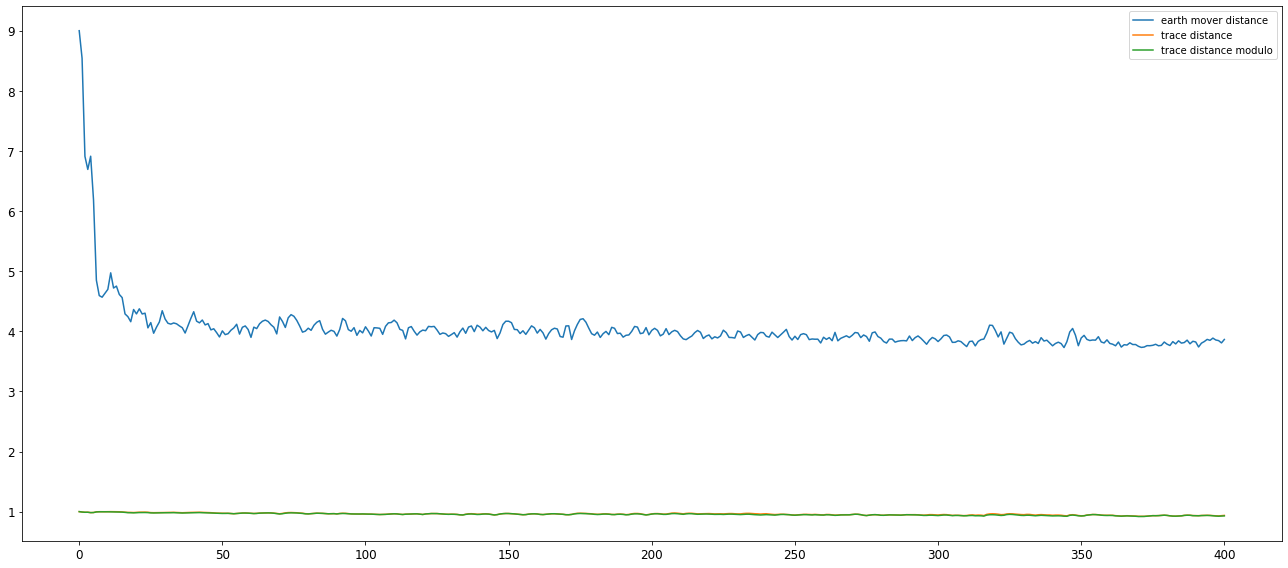

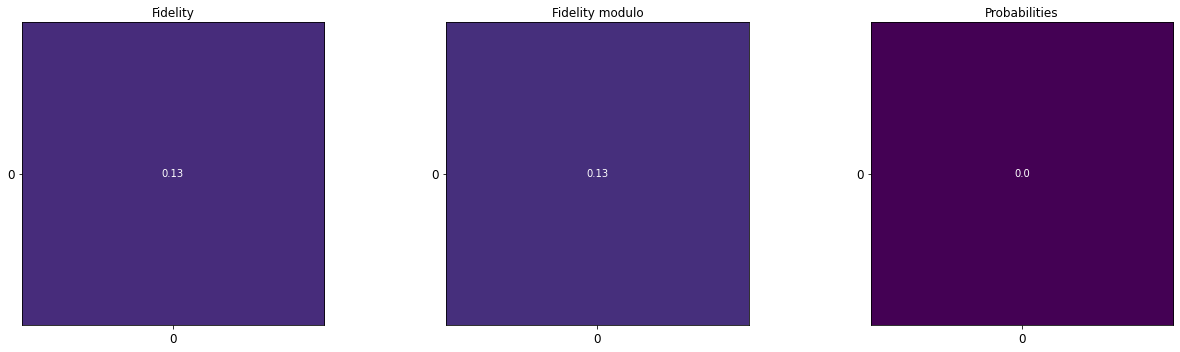

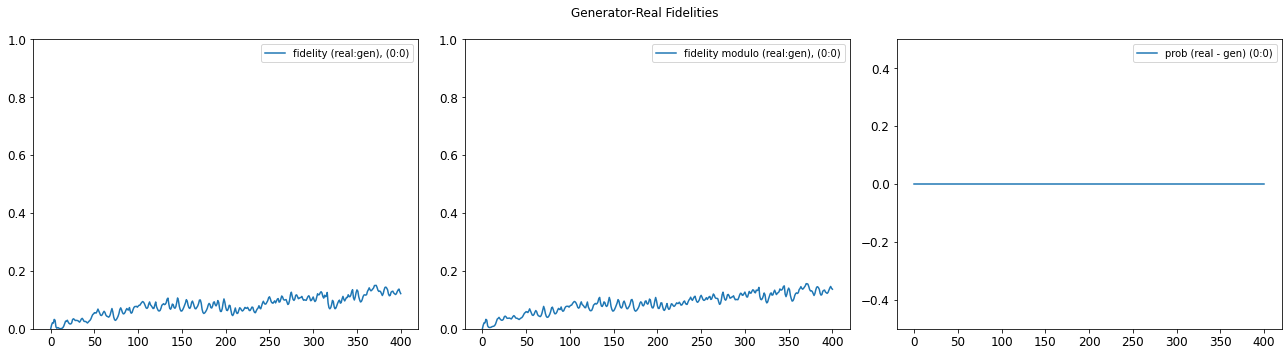

----------------------------------------------------
Epoch 400:  EM distance = 3.8635542576344983, trace distance = 0.937287894785053, abs trace distance = 0.9291167824958624
h=Z((0, 5))*Z((0, 8)), w=0.9999997878664962, e=0.8996842429041862
h=X((0, 6)), w=-0.9999998272649702, e=-0.2639150619511173
h=Z((0, 0))*Z((0, 3)), w=-0.9999998027369311, e=-0.9079805463552475
h=Z((0, 1))*Z((0, 4)), w=-0.9999998474942118, e=-0.9074409827589989
h=Z((0, 2))*Z((0, 7)), w=-0.9999997878469179, e=-0.884534165263176
-------------------------------------
----------- TRAINING DONE -----------


In [88]:
# gen_iteration = 1
# snapshot_interval_epochs = 200
# epochs = 401
training_result = {}
trainer_dict = {}
for i, data_bus_size in enumerate(sizes):
    trainer_by_size = {}
    result_by_size = {}
    real_expectations_provider = None
    for j, g in enumerate(g_values):
        training_result[(j, g)] = result_by_size
        trainer_dict[(j, g)] = trainer_by_size
        data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)
        
        if real_circuit_type == 'butterfly':
            real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
            real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
        else:
            builder = PhaseCircuitBuilder(all_gates_parametrized=False, g_positive=g_positive)
            real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
            real_values_provider = get_g_parameters_provider()

        if generic_generator:
            gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
            symbols_dict_gen = {}
        else:
            if real_circuit_type == 'butterfly':
                gen, gs = ButterflyCircuitBuilder("g").build(qubits=qubits)
            else:
                builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized, g_positive=g_positive)
                gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)        
        if expectation_provider_type == ExpectationProviderType.ONLY_KNOWN:
            known_g_values = [g]
        if real_expectations_provider is None:
            real_expectations_provider = get_expectation_provider(real, real_symbols, known_g_values, real_values_provider)

        trainer_by_size[(i, data_bus_size)] = Trainer(real, 
                                                      real_symbols, 
                                                      gen, 
                                                      gs, 
                                                      [g], 
                                                      real_values_provider, 
                                                      real_expectations_provider,
                                                      rank=rank, 
                                                      k=k,
                                                      use_neptune=use_neptune)
        
        opt = tf.keras.optimizers.Adam(0.1, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
                
        start_neptune_experiment(trainer_by_size[(i, data_bus_size)])

        json_result = trainer_by_size[(i, data_bus_size)].train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)
#         training_result[(i,data_bus_size)] = json_result
        
        if use_neptune:
            neptune.stop()


In [ ]:
# print fidelities of each generator
# get all hamiltonians of each discriminator (final iteration) - r
r = defaultdict(lambda: defaultdict(list))
# rg = defaultdict(lambda: defaultdict(list))
for j, g in enumerate(g_values):
    for i, s in enumerate(sizes):
        print(f"({j},{g}), ({i}, {s})" \
              f"abs_fidelity: {trainer_dict[(j, g)][(i, s)].last_run_generator_weights[-1].fidelities[0].abs_fidelity}")
        for k,v in trainer_dict[(j, g)][(i, s)].last_run_generator_weights[-1].disc_w_h.items():
            r[g][str(v)].append(i)
            r["COMBINED"][str(v)].append(i)
#             if g_dict[(i, g)].last_run_generator_weights[-1].trace_distance > 0.9:
#                 rg[g][str(v)].append(i)
r

In [74]:
trainer_dict
trainer = trainer_dict[(0, -1)][(0,5)]

In [32]:
np.set_printoptions(suppress=True)
def get_expectations_real(g, t):
    full_weights = tf.keras.layers.Layer()(
                tf.Variable(np.array(t.real_values_provider(g), dtype=np.float32)))
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.real_expectation([t.real],
                                         symbol_names=t.real_symbols,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_expectations_gen(g, t):
    full_weights = tf.keras.layers.Layer()(t.gen_weights[0][2])
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.gen_expectation([t.gen],
                                         symbol_names=t.gs,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_exps(g_list, trainer, eps=1e-3):
    res = defaultdict(list)
    for g in g_list:
        for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) >= eps):
            res[e[0]].append(e[1])
    return res

def get_exp(g, trainer, eps=1e-3):
    res_r = defaultdict(list)
    res_g = defaultdict(list)
    for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) >= eps ):
        res_r[e[0]].append(e[1])
    for e in (fe for fe in get_expectations_gen(g, trainer).items() if abs(float(fe[1])) >= eps ):
        res_g[e[0]].append(e[1])
    return res_r, res_g

X((0, 2))*X((0, 3)) [-0.089819886]
X((0, 1))*Y((0, 3)) [0.14400743]
Y((0, 0))*Z((0, 1)) [0.26660538]
X((0, 0))*X((0, 2)) [0.5525691]
Z((0, 0))*X((0, 1)) [-0.0253136]
Y((0, 1))*X((0, 2)) [0.010542344]
Y((0, 0))*X((0, 3)) [0.03054242]
Z((0, 0))*Y((0, 1)) [0.018403895]
Z((0, 0))*Z((0, 1)) [0.6562516]
Y((0, 0))*X((0, 1)) [0.20078015]
Z((0, 2))*X((0, 3)) [-0.016349088]
X((0, 1))*Y((0, 2)) [-0.1150038]
X((0, 2))*Y((0, 3)) [-0.16603233]
X((0, 0))*X((0, 1)) [-0.013008041]
Y((0, 2))*Y((0, 3)) [0.10751206]
Z((0, 0))*Y((0, 3)) [0.56910574]
Y((0, 1))*Y((0, 2)) [-0.026627673]
X((0, 0))*Z((0, 1)) [0.08840677]
Y((0, 0)) [-0.33685422]
Y((0, 2)) [0.03639953]
Z((0, 1))*Z((0, 3)) [0.10845948]
Y((0, 0))*Z((0, 3)) [0.02853582]
Z((0, 2))*Y((0, 3)) [0.6396657]
Y((0, 0))*X((0, 2)) [-0.36755347]
Z((0, 0)) [-0.494626]
X((0, 0))*Y((0, 1)) [0.17693163]
Y((0, 1))*Y((0, 3)) [0.11202803]
Z((0, 2))*Z((0, 3)) [0.17537658]
X((0, 0))*Z((0, 2)) [0.2549595]
Z((0, 1))*Y((0, 3)) [0.8696197]
X((0, 1))*Z((0, 3)) [0.3293814]
Y

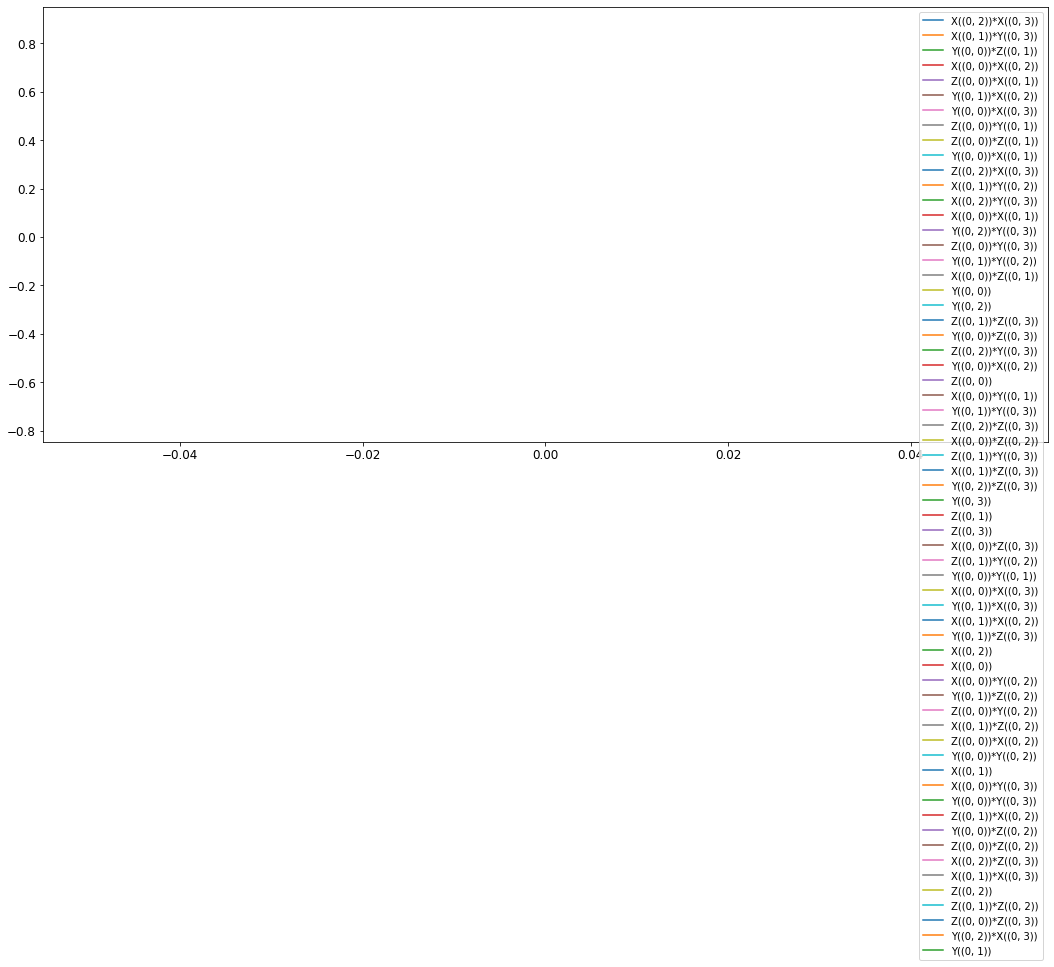

defaultdict(list,
            {'X((0, 2))*X((0, 3))': [-0.089819886],
             'X((0, 1))*Y((0, 3))': [0.14400743],
             'Y((0, 0))*Z((0, 1))': [0.26660538],
             'X((0, 0))*X((0, 2))': [0.5525691],
             'Z((0, 0))*X((0, 1))': [-0.0253136],
             'Y((0, 1))*X((0, 2))': [0.010542344],
             'Y((0, 0))*X((0, 3))': [0.03054242],
             'Z((0, 0))*Y((0, 1))': [0.018403895],
             'Z((0, 0))*Z((0, 1))': [0.6562516],
             'Y((0, 0))*X((0, 1))': [0.20078015],
             'Z((0, 2))*X((0, 3))': [-0.016349088],
             'X((0, 1))*Y((0, 2))': [-0.1150038],
             'X((0, 2))*Y((0, 3))': [-0.16603233],
             'X((0, 0))*X((0, 1))': [-0.013008041],
             'Y((0, 2))*Y((0, 3))': [0.10751206],
             'Z((0, 0))*Y((0, 3))': [0.56910574],
             'Y((0, 1))*Y((0, 2))': [-0.026627673],
             'X((0, 0))*Z((0, 1))': [0.08840677],
             'Y((0, 0))': [-0.33685422],
             'Y((0, 2))': [0.036

In [45]:
# plot change in the expectation per pauli string
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
g_values_list = [-0.5]
# random.shuffle(g_values_list)
es = get_exps(g_values_list, trainer_dict[(0, -1)][(0, 4)])
res = []
for k, v in es.items():
    c = []
    for i in range(len(v)):
          c.append(float(v[i]))
    res.append(c)
    x = list(range(len(c)))
    axes.plot(x, c,label=k)
    print(k, v)
axes.legend()
plt.show()
es

In [6]:
def merge_exps(g_values_list, trainer_negative, trainer_positive, eps=0):
    exps_n = get_exps([v for v in g_values_list if v <= 0], trainer_negative, eps=eps)
    exps_p = get_exps([v for v in g_values_list if v > 0], trainer_positive, eps=eps)
    return {k: v + exps_p[k] for k, v in exps_n.items()}

[-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


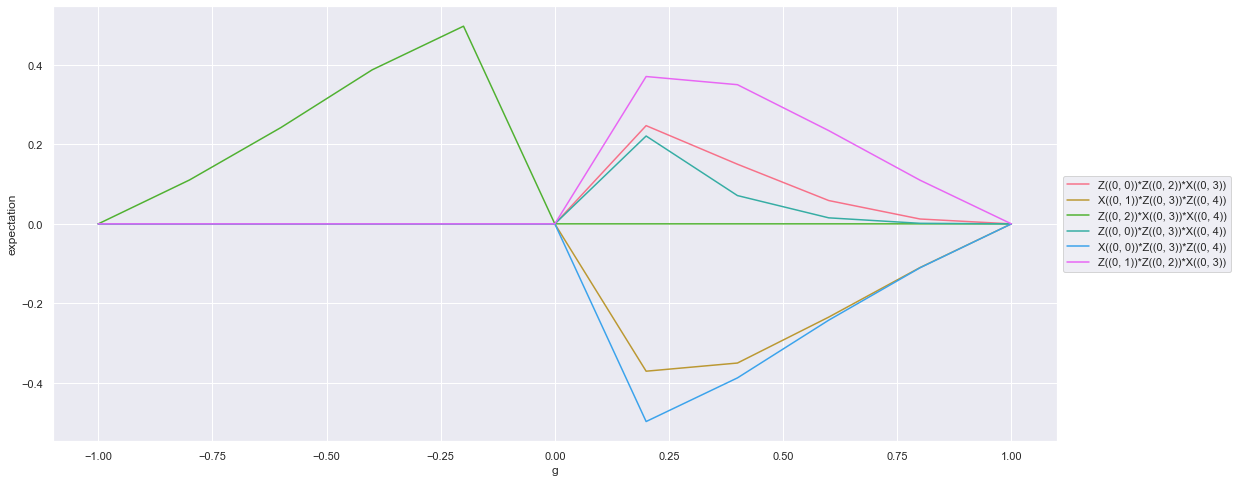

In [37]:
# plots expecation change for different g for all pauli string with expecation higher than eps
import seaborn as sns
sns.set()
sns.set_palette("husl")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
g_values_list = [np.round(el, 3) for el in np.linspace(-1,1,11)]
x_indexes = False
print(g_values_list)
# random.shuffle(g_values_list)
eps = 1e-3
res = merge_exps(g_values_list, trainer, trainer_p, eps=0)
curated_res = {k: v for k, v in res.items() if any(abs(el) > eps for el in res[k])}
curated_res = list(curated_res.items())
random.shuffle(curated_res)
for pauli_string, exp in curated_res[:6]:
    if x_indexes:
        axes.plot(range(len(g_values_list)), exp, label=pauli_string)
    else:
        axes.plot(g_values_list, exp, label=pauli_string) 
axes.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes.set_xlabel("g")
axes.set_ylabel("expectation")
plt.show()

from pathlib import Path
FIG_PATH_PREFIX = "/Users/wiktorjurasz/Studies/thesis/paper/figures"
Path(f"{FIG_PATH_PREFIX}/phase_exps").mkdir(exist_ok=True)
# fig.savefig(f"{FIG_PATH_PREFIX}/phase_exps/plot.png", bbox_inches='tight')

In [47]:
# calculates expectations of each pauli string for all sizes of circuits
circuits_gen = []
circuits_real = []
size_to_exps_real = {}
size_to_exps_gen = {}
g = -0.8
eps = 1.e-5
for j, g in enumerate(g_values):
    for i, s in enumerate(sizes):
        tr = trainer_dict[(j, g)][(i, s)]
        size_to_exps_real[s] = get_expectations_real(g, tr)
        size_to_exps_gen[s] = get_expectations_gen(g, tr)
        circuits_gen.append(tr.gen_evaluator.get_all_resolved_circuits()[0][2])
        circuits_real.append(tr.real_evaluator.get_all_resolved_circuits()[0][2])
string_to_exp = defaultdict(list)
for s, exps_real in size_to_exps_real.items():
    exps_gen = size_to_exps_gen[s]
    for pauli_string, exp_real in exps_real.items():
        exp_gen = exps_gen[pauli_string]
        string_to_exp[pauli_string].append((exp_real, exp_gen))
curated_string_to_exp = {k: v for k, v in string_to_exp.items() if any(abs(float(el[0])) > eps for el in string_to_exp[k])}

In [48]:
curated_string_to_exp

{'X((0, 2))*X((0, 3))': [(0.0060501443, -0.0010470473),
  (-0.1990518, -0.20047413),
  (0.11189297, 0.06506403),
  (-0.16255088, -0.18570057),
  (0.20274949, 0.19389631),
  (-0.3998146, -0.34472057),
  (-0.0068144486, -0.0018948738)],
 'X((0, 1))*Y((0, 3))': [(0.007853701, 0.0101240445),
  (0.06724385, 0.092393585),
  (0.030431489, -2.6535636e-05),
  (-0.0046109324, 0.12353668),
  (-0.084467806, -0.059199005),
  (0.12161643, 0.13338159),
  (0.17052041, 0.24506535)],
 'Y((0, 0))*Z((0, 1))': [(-0.23672995, -0.24784777),
  (-0.06971222, -0.19931802),
  (0.5253102, 0.54228413),
  (-0.044145238, -0.08024673),
  (-0.15118201, -0.1283126),
  (-0.52318674, -0.51540023),
  (-0.1339444, -0.33226576)],
 'X((0, 0))*X((0, 2))': [(0.1057434, 0.1121717),
  (-0.07344143, -0.10869008),
  (0.13567165, 0.13645606),
  (-0.23819941, 0.04027897),
  (0.05039459, 0.05173193),
  (-0.2005372, -0.2448419),
  (0.0079826135, 0.0020166093)],
 'Z((0, 0))*X((0, 1))': [(-0.056218833, -0.055995155),
  (-0.06358238, -0.

In [ ]:
def remove_last_n_qubits(circuit, n):
    circuit = circuit.copy()
    qubits_to_remove = sorted(list(circuit.all_qubits()))
    circuit.clear_operations_touching(qubits_to_remove[-n:], list(range(len(circuit.moments))))
    return circuit

In [ ]:
# get fidelity between truncated and trained circuit
truncated_circuit = remove_last_n_qubits(circuits_gen[1], 1)
cirq.fidelity(abs(cirq.final_state_vector(truncated_circuit)), abs(cirq.final_state_vector(circuits_gen[0])))

In [ ]:
def combine_circuits(circuit, smaller_symbol_value_pairs, larger_symbol_value_pairs, larger_to_smaller_map):
    combined_pairs = larger_symbol_value_pairs.copy()
    for ls, ss in larger_to_smaller_map.items():
        combined_pairs[ls] = smaller_symbol_value_pairs.get(ss, larger_symbol_value_pairs[ls])
    resolver = cirq.ParamResolver(combined_pairs)
    return cirq.final_state_vector(cirq.resolve_parameters(circuit, resolver))

def get_symbols_per_qubit(circuit):
    qubit_to_symbols = defaultdict(list)
    for op in circuit.all_operations():
        symbol = op.gate.exponent
        if len(symbol.args) > 1:
            symbol = symbol.args[0]
        q = op.qubits[-1]
        qubit_to_symbols[q].append(symbol)
    return qubit_to_symbols

def match_symbols(larger_circuit, smaller_circuit):
    matched = {}
    for q, symbols_smaller in smaller_circuit.items():
        symbols_larger = larger_circuit[q]
        for bs, ss in zip(symbols_larger, symbols_smaller):
            matched[bs] = ss
    return matched

In [ ]:
# get fidelity between trainer and combined circuit (generator)
# smaller circuit (generator) weights are used in the larger when 
# (for the qubits that are common for both the rest is from the larger one)
smaller = trainer_dict[(0,-0.8)][(0,3)]
larger = trainer_dict[(0,-0.8)][(1,4)]
cirq.fidelity(abs(combine_circuits(larger.gen, 
                 smaller.gen_evaluator.symbol_value_pairs[0][2], 
                 larger.gen_evaluator.symbol_value_pairs[0][2],
                 match_symbols(get_symbols_per_qubit(g_dict[(1, 4)].gen), 
                                   get_symbols_per_qubit(smaller.gen)))), 
              abs(larger.gen_evaluator.get_all_states_from_params()[0][2]))

In [ ]:
precomp_exp_provider = PrecomputedExpectationsProvider(trainer.real, trainer.real_symbols,  np.linspace(-1,0,11), real_values_provider

In [ ]:
interpolation_1d_expectations_provider = Interpolation1DExpectationsProvider(precomp_exp_provider)

In [ ]:
interpolation_1d_expectations_provider.get_expectations_for_parameters([-0.75])

In [ ]:
gen_input_dim = 10
hidden_dim = 32
penalty_factor = 10
epochs = 5000
batch_size = 4
wgan_exp_provider = WassersteinGanExpectationProvider(precomp_exp_provider, gen_input_dim, hidden_dim, penalty_factor, epochs, batch_size)

In [ ]:
wgan_exp_provider.initialize()

In [ ]:
wgan_exp_provider.get_expectations_for_parameters([2])

In [ ]:
(trainer.real_expectations_provider.generator(tf.random.normal([1, trainer.real_expectations_provider.gen_input_dim])).numpy()[0] * 2) - 1

In [ ]:
re_exps = trainer.real_expectations_provider.get_expectations_for_parameters([1])[1]
{s: e for s, e in re_exps.items() if abs(e) > 0.1}

In [ ]:
trainer.real_expectations_provider.precomputed_expectations_provider.eps = 0.1
trainer.real_expectations_provider.precomputed_expectations_provider.get_expectations_for_parameters([2], filter_small_expectations=True)

In [ ]:
trainer.real_evaluator.get_resolved_circuit()

In [ ]:
trainer.gen_evaluator.get_resolved_circuit()

In [ ]:
trainer.gen_evaluator.get_state_from_params()

In [ ]:
trainer.real_evaluator.get_state_from_params()

In [ ]:
cirq.fidelity(trainer.gen_evaluator.get_state_from_params()[1], trainer.real_evaluator.get_state_from_params()[0])

In [ ]:
re, ge = get_exp(-0.5, trainer, eps=0)

In [ ]:
ce = defaultdict(list)
for k, v in re.items():
    ce[k].append(v[0])
    ce[k].append(ge[k][0])
for k, v in ce.items():
    ce[k] = [el if abs(el) > 1.e-2 else 0 for el in v]

ce

In [ ]:
print("------STRING ORDER PARAMETERS------")

In [ ]:
measure_s1_pauli_string(trainer.real_evaluator.get_resolved_circuit(-0.5))

In [ ]:
measure_s1_pauli_string(trainer.gen_evaluator.get_resolved_circuit())

In [ ]:
measure_szy_pauli_string(trainer.real_evaluator.get_resolved_circuit(-0.5))

In [ ]:
measure_szy_pauli_string(trainer.gen_evaluator.get_resolved_circuit())

In [ ]:
cirq.fidelity(np.array([0.7,0.7]), np.array([0.7j,-0.7j]))

In [ ]:
q1 = cirq.GridQubit.rect(1, 1)
q2 = cirq.GridQubit.rect(1, 1)
circuit1 = cirq.Circuit(cirq.H(q1[0]))
circuit2 = cirq.Circuit(cirq.H(q2[0]), cirq.Y(q2[0]), cirq.X(q2[0]))

In [ ]:
cirq.fidelity(cirq.final_state_vector(circuit1), cirq.final_state_vector(circuit2))

In [ ]:
ex = tfq.layers.Expectation()

In [ ]:
ex(circuit1, operators=cirq.PauliString([cirq.X(q1[0])]))

In [180]:
ex(circuit2, operators=cirq.PauliString([cirq.X(q2[0])]))

NameError: name 'ex' is not defined

In [181]:
neptune.stop()

NeptuneNoExperimentContextException: 
[95m  
----NeptuneNoExperimentContextException---------------------------------------------------------------------------------
[0m
Neptune couldn't find an active experiment.

Looks like you forgot to run:
    [96mneptune.create_experiment()[0m
    
You may also want to check the following docs pages:
    - https://docs-legacy.neptune.ai/getting-started/quick-starts/log_first_experiment.html

[92mNeed help?[0m-> https://docs-legacy.neptune.ai/getting-started/getting-help.html


Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stderr. Invalid point: 2021-07-24T16:02:34.032Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stderr. Invalid point: 2021-07-24T16:02:34.034Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stderr. Invalid point: 2021-07-24T16:02:34.036Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stderr. Invalid point: 2021-07-24T16:02:34.038Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stderr. Invalid point: 2021-07-24T16:02:34.040Z
Error occurred during asynchronous operation processing: Timestamp must be non-decreasing for series attribute: monitoring/stderr. Invalid point: